# Sentiment Analysis of Political Tweets

## Rebecca Stewart



### Overview

The goal of this project is to analyze political tweets. 

I start by using my custom twitter objects, which uses the Tweepy API and its Cursor method, to pull tweets for various politicians.  I then pre-process/clean these tweets, do a bit of feature engineering, analyze the data via visualizations and summarize my findings. 

The two most interesting features will be;
1.	<b>Sentiment of Tweet</b> (Positive/Neutral/Negative) – which is based on the VADER library’s calculation of polarity scores.
2.	<b>Political Affiliation</b> of person that created the tweet – which is based on their congressional title. Easy to look up.

The two less interesting features will be;
1. Number of likes a tweet got.
2. Length of tweet.

The tweets I will pull all belong to the 2019 "Gang of Eight". This group of 8 lawmakers, who are considered the leaders of the US congress, consist of 4 democrats and 4 republicans. I chose to analyze the tweets from this group of politicians since it is perfectly clear which political party each is affiliated with, making it easy to group my data between Republican vs Democrat. It also lets me control how many tweets to pull from each side of the political spectrum, keeping a good balance between the two groups.

After I do some initial cleaning of the tweet text and engineer a few features, I let VADER (Valence Aware Dictionary and sEntiment Reasoner) analyze each so that I can save it’s estimated sentiment into the dataframe as both a polarity score and as one of three categories; Positive, Neutral and Negative.

My intent with the analysis part of the project is to look for trends or correlations between the various features; Political affiliation, sentiment, number of likes and tweet length. We will accomplish this by creating and interpreting multiple visualizations of the data, from simple charts to word clouds.



### Import Libraries 

In [42]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import scipy.stats as ss
import statsmodels.stats.weightstats as ws

import twitter_credentials
import string
import demoji

import tweepy
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk import bigrams 
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm import tqdm_notebook as tqdm
import spacy
from wordcloud import WordCloud, STOPWORDS 
from collections import  Counter

### Initiate lists/objects

In [5]:
sns.reset_defaults()
sns.set_style("whitegrid")
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
punctuation = list(string.punctuation)
punctuation =   string.punctuation + "’"+ "‘" + "•" 
word_tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()
# demoji.download_codes()
sid = SentimentIntensityAnalyzer()

### The TwitterClient object 

The following python object is used to pull tweets from twitter. The last four functions use Tweepy's cursor method to pull tweets based on user, search word, friend list and/or number of tweets. These functions use a progress bar to show progress. 

Although I only plan to use the <b>get_user_tweets</b> method for this project (since I will only be pulling tweets based on specific users) - I do plan to use the other methods in future projects, so I will leave these methods in the following class definition for completeness, and so that I can re-use this code in the future.

In [6]:
#### TWITTER CLIENT #####

class TwitterClient():
    """ The initialization of this TwitterClient object will use TwitterAccess to authenticate with the Twitter API
    The remaining methods use Tweepy's Cursor method to pull tweets from Twitter  
    """
    def __init__(self, twitter_user=None):
        """ Creating an instance of this object allows one to optionally specify a specific twitter_user, but will default to None)
        After authentication, the twitter_client and twitter_user attributes are set  
        """
        self.auth = TwitterAccess().authenticate()
        self.twitter_client=API(self.auth)
        self.twitter_user=twitter_user
    
    def get_twitter_client(self):
        """ Returns twitter_client (API object) 
        """
        return self.twitter_client
    
    def get_topic_tweets(self,search_words, num_tweets):
        """ Returns tweets based on search words and number of tweets 
        """
        tweets=[]
        try:
            
            tweetsObj = Cursor(self.twitter_client.search,  q=search_words+"  -filter:retweets  -filter:replies", tweet_mode='extended').items(num_tweets)
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                tweets.append(tweet)
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e)        
        return tweets
    
    def get_user_tweets(self,num_tweets):
        """ Returns tweets based on specific user and number of tweets 
        """
        tweets=[]
        try:
            tweetsObj = Cursor(self.twitter_client.user_timeline, q=" -filter:retweets", id=self.twitter_user, tweet_mode='extended').items(num_tweets)
            #for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                tweets.append(tweet)
        
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e) 
        return tweets
    
    def get_friend_list(self, num_friends):
        """ Returns friend list of specific user, limited by number of friends 
        """
        friend_list=[]
        try:
            tweetsObj = Cursor(self.twitter_client.friends, id=self.twitter_user, tweet_mode='extended').items(num_friends)
            
            pBar = tqdm(tweetsObj, ascii=True, total=num_friends, desc="Getting Friends!")
            for cnt, friend in enumerate(pBar):
                pBar.update(1)
                friend_list.append(friend)
            
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e)         
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        """ Returns home timeline tweets, limited by number of tweets 
        """
        home_timeline_tweets=[]
        try:
            tweetsObj= Cursor(self.twitter_client.home_timeline, id=self.twitter_user, tweet_mode='extended').items(num_tweets)
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                home_timeline_tweets.append(tweet)
                
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e) 
        return home_timeline_tweets


### The TwitterAccess object 

This python object only has one objective, and that is to get an authorization from Tweepy using identifying and secret API information. Make sure that a text document, titled "twitter_credentials.py" is saved in the same location as this project and specifies information for these four variables; ACCESS_TOKEN, ACCESS_TOKEN_SECRET, CONSUMER_KEY, and CONSUMER_SECRET.

Information about how to obtain twitter credentials can be found on <a href="https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens">developer.twitter.com</a>


In [7]:
#### TWITTER AUTHENTICATER ####

class TwitterAccess():
    """ The initialization of this TwitterAccess object will use OAuthHandler to authenticate with the Twitter API
    Make sure the four twitter credentials are stored locally in a file called twitter_credentials.py
    """
    def authenticate(self):
        try: 
            auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
            auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        except tweepy.error.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}") 
        return auth

### Build the TweetStorage object 

This python object deals with converting tweet data into a dataframe, either from tweet data recently pulled from the Twitter API or from a local text file.


In [8]:
class TweetStorage():
    """ This TweetStorage object has three methods, one to convert raw tweet data (recently pulled from the Twitter) into a
    dataframe, one to pull previously saved tweeter data from a local csv file, convert it to a dataframe. Both of these 
    methods return this dataframe. The final method saves a dataframe to a local csv file.
    """
   
    def tweets_to_data_frame(self, tweets):
        
        try: 
            df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['tweets'])
            df['id']=np.array([tweet.id for tweet in tweets])
            df['len']=np.array([len(tweet.full_text) for tweet in tweets])
            df['full_text']=np.array([tweet.full_text for tweet in tweets])
            df['date']=np.array([tweet.created_at for tweet in tweets])
            df['author_name']=np.array([tweet.user.screen_name for tweet in tweets])
            df['likes']=np.array([tweet.favorite_count for tweet in tweets])
            df['retweets']=np.array([tweet.retweet_count for tweet in tweets])
            df['in_reply_to_status_id']=np.array([tweet.in_reply_to_user_id for tweet in tweets])
            
            return df
        except tweepy.TweepError as e:
            print(f"Error: Saving tweets to dataframe failed - \n{str(e)}") 
            
      
    def tweets_from_csv_to_data_frame(self, file_name):
        
        try: 
            tdf = pd.read_csv(file_name, sep = ',', header=0)
        except error as e:
            print(f"Error: Loading tweets from file failed - \n{str(e)}") 
        return tdf
    
    def tweets_from_data_frame_to_csv(self, df, file_name):
        
        try: 
            df.to_csv(file_name, index=False, encoding='utf-8')    
            
        except error as e:
            print(f"Error: Saveing tweets to file failed - \n{str(e)}") 
        


### Helper Functions


In [58]:

def user_tweets_bar_chart(user_tweets):
    ax = user_tweets.plot(kind='bar', color = ['red','gold','skyblue','green','orange','teal','cyan','lime','orangered','aqua'], fontsize=12)
    ax.set_title("Tweets By Users\n", fontsize=24)
    ax.set_xlabel("Users", fontsize=20)
    ax.set_ylabel("Tweets", fontsize=20)
    plt.show()
    
# Function to return one of 5 possible types for the POS tag 
def get_tag_type(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Function to remove stop words as defined by nltk - I am keeping this separate from the CleanTweets
# function because I may not always want to remove stopwords, depending on the type of model I am creating

def remove_stop_words(text):
    tokenized_text =word_tokenizer.tokenize(text)  
    stop_words = set(stopwords.words("english"))
    stop_words.add("amp")
    stop_words = set(stop_words)
    tokenized_text = [w for w in tokenized_text if not w in stop_words and len(w) >= 3]
    return " ".join(tokenized_text)

# This function formats the data in such a way as to create and display word clouds

def show_word_cloud_for_tweets(dataframe):
     # Create a document storage matrix
    clean_texts = dataframe['clean_tweet']
    tweet_word_counts = {}
    
    for ix, row in enumerate(clean_texts):
        words = row.split(' ')
        for word in words:
            if word in tweet_word_counts:
                tweet_word_counts[word] += 1
            else:
                tweet_word_counts[word] = 1

    stopwords = set(STOPWORDS) 

    wordcloud = WordCloud(width = 350, height = 150, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6).generate_from_frequencies(tweet_word_counts) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
    

def get_regress_line(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope*x+intercept


def count_common(df, num_common):
    wordcount = {}
    for tweet in df['clean_tweet']:
        tokens = word_tokenizer.tokenize(tweet)
        for word in tokens:
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
    counter=Counter(wordcount)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:num_common]:
        x.append(word)
        y.append(count)
    return x, y

### Functions to Clean/Pre-process Tweets

The first function, CleanTweets, removes screen names, links and hashtags, as well as lemmatizes the words with the help of part-of-speech tagging.

The second function, ProcessText, performs some of the more traditional pre-processing, like removing emojis, punctuation, numbers as well as converting all to lower case. 

I am using two functions instead of one for pre-processing since the sentiment analyzer tool, VADER, works best for text that has not been extensively cleaned. Items that would normally be removed from text during the pre-processing step, like punctuation and emoticons, are used by VADER when estimating sentiment.     
    

In [10]:
#Function to preprocess a single tweet
def CleanTweets(tweet_dirty):
    """
    This function cleans/pre-processes tweets by doing several things
    Remove the following; Screen Names, URL's, Hashtags
    Convert from a string to a list of lowercase tokens that have been lemmatized
    """
    print_tweet_text = False

    # SCREEN NAMES - Use regular expression to remove user screen names, which start with @ symbol
    tweet_in_process = re.sub("@\w+","",tweet_dirty).strip()
    if print_tweet_text: print(tweet_in_process)
    
    # URLs - Use regular expression to remove URLs
    tweet_in_process = re.sub("http\S+","",tweet_in_process).strip()
    if print_tweet_text: print(tweet_in_process)
      
    # REMOVE HASHTAGS - Use regular expression to remove hashtags 
    tweet_in_process = re.sub("#\w+","",tweet_in_process).strip() 
    if print_tweet_text: print(tweet_in_process)
    
    

    # NUMBERS- remove  numbers
    tweet_in_process = re.sub('[0-9]+', '', tweet_in_process)
    if print_tweet_text: print(tweet_in_process)
   

    return tweet_in_process

In [11]:
#Function to preprocess a single tweet
def ProcessText(tweet_dirty):
    """
    This function cleans/pre-processes tweets by doing several things
    Remove the following; Screen Names, URL's Emojis, Hashtags, Punctuation, Numbers
    Convert from a string to a list of lowercase tokens that have been lemmatized
    """
    print_tweet_text = False
    
    # EMOJIS - Use the demoji ovject to replace emojis with empty strings
    tweet_in_process=demoji.replace(tweet_dirty)
    if print_tweet_text: print(tweet_in_process)
    
    # CHANGE CASE - Change the case of all text to lower case 
    tweet_in_process = tweet_in_process.lower()
    if print_tweet_text: print(tweet_in_process)
    
    # PUNCTUATION AND  - remove punctuation 
    tweet_in_process  = "".join([char for char in tweet_in_process if char not in punctuation])
    if print_tweet_text: print(tweet_in_process)
        
     # TOKENIZE INTO WORDS - Tokenize  the tweet into words
    tokenized_tweet =word_tokenizer.tokenize(tweet_in_process)   
    if print_tweet_text: print(tokenized_tweet)
    
    # FIND PART-OF-SPEACH(POS) - This POS tag will be used during the lemetization process
    pos_tags_tweet = pos_tag(tokenized_tweet)
    if print_tweet_text: print(pos_tags_tweet)
        
    # LEMMATIZE WORDS with POS type - this one should perform better
    tokenized_tweet = [lemmatizer.lemmatize(tag[0], get_tag_type(tag[1])) for tag in pos_tags_tweet]
    if print_tweet_text: print(tokenized_tweet)
      
  
    return " ".join(tokenized_tweet)

### Main Code  - Time to build our twitter dataset!

<b>Now that we have built all our objects and functions for interacting with the Twitter API and processing the data, we can specify exactly what we what we want and where we want to pull it from.</b>

The first time running this code, we set "get_new_tweets" to true, which allows us to pull new tweets using our twitter objects. Depending on how many we pull, this could take some time. Luckily, our process bars will give us something to pay attention to while we wait. 

But, we don't need to pull new tweets every time we run the code in this project. Since we are saving this data to a local csv file, we can choose to use this data to populate our dataframe.  This allows subsequent runs of this project's code to run faster.

Either way, we will now do the following four things:

1. Specify number of Tweets 
2. Build list of users we will pull tweets for. 
3. Populate our tweet dataframe - either pull from our Twitter Client object or from a local csv file
4. Call the CleanTweets function and pass the full_text of each tweet. The returned cleaned tweet text is added to our dataframe as a new feature. 

Without paying for an upgraded Twitter API account, I am limited in how I can pull tweets. If I pull tweets via a user's timeline, I am able to pull up to 3200 tweets, but I can't restrict re-tweets or replies. If I pull tweets via a search query, I can specify the user using "from:username" in the search query, and I can add indicators to block re-tweets or replies, but only those tweets from the last week will be returned. And for the politicians in question, that amounts to only a small number of tweets. So I have opted to use the user_timeline and filter out retweets and replies manually. This means we may not end up with the same number of tweets for each class of political affiliation.

Because I know in advance that almost half of Devin Nunes tweets are re-tweets almost none of Adam Schiff's are, I can specify some weights for our number_tweets variable - so that the call pulls more/less. Being able to control the number of tweets means we can make adjustments to ensure we don't end up with class imbalance.

In [12]:
get_new_tweets=True
number_tweets=1200
tweet_store= TweetStorage()
user_name_list = ["RepAdamSchiff", "DevinNunes", "SenatorBurr", "MarkWarner", "SpeakerPelosi", "GOPLeader", "senatemajldr", "SenSchumer"]
user_name_RT_weight = [1, 1.6, 1.1, 1.5,1.2, 2.1, 1, 1]
name_and_weight =zip(user_name_list, user_name_RT_weight)

# For each user, pull specified number of tweets and append data to our data frame.
if get_new_tweets:
    df=None
    for user, weight in name_and_weight:  
        twitter_client=TwitterClient(user)
        tweets = twitter_client.get_user_tweets(number_tweets*weight)
       
        user_df=tweet_store.tweets_to_data_frame(tweets)
        # Manually Remove Retweets - those would be tweets that start with the letters RT followed by a space and username(which begins with @)
        try:  
            user_df=user_df[~user_df["full_text"].str.startswith("RT @")]
        except:
            print("Error: Empty Dataframe") 
        print("Non-Retweet Tweets: " + str(user_df.shape[0]) + " out of " + str(number_tweets*weight))
        
        try:
            df=df.append(user_df, ignore_index = True)    
        except:
            df=user_df  
       
    # Clean tweets
    df["clean_tweet"] = df["full_text"].apply(CleanTweets)
    # Make sure the text isn't just these two words
    df = df[df['full_text'] != "Not Available"]
    # Make sure there are no NaN valuse
    df = df[pd.notnull(df['clean_tweet'])]    
    # Save the tweets to a data file 
    tweet_store.tweets_from_data_frame_to_csv(df, 'tweets.csv')
   
else:
    
    df = tweet_store.tweets_from_csv_to_data_frame("tweets.csv")
    df = df[pd.notnull(df['clean_tweet'])]  



Non-Retweet Tweets: 1185 out of 1200



Non-Retweet Tweets: 1068 out of 1920.0



Non-Retweet Tweets: 1167 out of 1320.0



Non-Retweet Tweets: 1222 out of 1800.0



Non-Retweet Tweets: 1147 out of 1440.0



Non-Retweet Tweets: 1213 out of 2520.0



Non-Retweet Tweets: 1155 out of 1200



Non-Retweet Tweets: 1133 out of 1200


### Initial Look at the Data - Number of Tweets per Person

Just to make sure we have roughly the same number of tweets per politician, we can group out tweets by author_name and show a graph of how many tweets per person we have in our dataset.

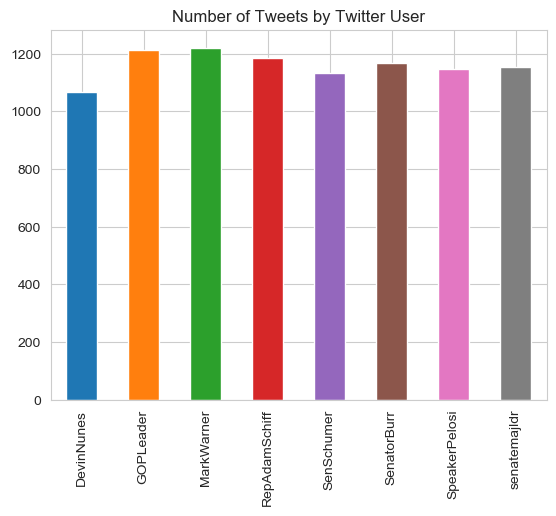

In [13]:
df.groupby(['author_name']).size().plot.bar()
plt.xlabel('')
plt.title("Number of Tweets by Twitter User")
plt.show()

### Feature Engineering - Political Affiliation

Since we can determine the political affiliation of each of our 8 politicians, it's a simple thing to construct the  variable "Democrat" - which will hold one of two values, True or False.  While we are at it, let's also go ahead and create a categorical variable, PoliticalAffil, which will help make our graphs more user friendly.

In [14]:
def is_democrat(user):
    democrats = ["RepAdamSchiff","MarkWarner","SpeakerPelosi","SenSchumer"]
    return user in democrats

In [15]:
df["Democrat"] = df["author_name"].apply(is_democrat)
df.loc[df.loc[:,"Democrat"]==True, "PoliticalAffil"]="Democrat"
df.loc[df.loc[:,"Democrat"]==False, "PoliticalAffil"]="Republican"


### Feature Engineering - Character Length and Word Count

This information might be interesting as we explore trends in our twitter data.

In [16]:
df['tweet_len'] = df['clean_tweet'].astype(str).apply(len)
df['word_count'] = df['clean_tweet'].apply(lambda x: len(str(x).split()))

### Feature Engineering  - Sentiment

Next, we will add a column that tracks estimated sentiment of each tweet. Because of it's success at estimating sentiment of text found in social media, we will use <a href='https://github.com/cjhutto/vaderSentiment' target='_blank'>VADER</a> (Valence Aware Dictionary and sEntiment Reasoner). 

Since punctuation, case, emojis all contribute to the success of VADER, we will use a version of cleaned text that does not have these removed. Instead, it only has usernames, hashtags, links and numbers removed. Once we calculate the polarity_scores for semi-cleaned tweets, this will allow us to see if there is a significant difference between the overall positive/negative sentiment scores between democratic and republican tweets. 

In [17]:
# Create a Sentiment Intensity Analyzer object and use it's polarity_scores function to analyze the polarity of each tweet
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["clean_tweet"].apply(lambda x: sid.polarity_scores(x))

# The new dataframe contains a few different pieces of information, which we can add to our main dataframe with concatination
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

# We use this new informaiton to create a feature called sentiment, which will include three possible values;
df.loc[df.loc[:,"compound"]<0, "sentiment"]="Negative"
df.loc[df.loc[:,"compound"]==0, "sentiment"]="Neutral"
df.loc[df.loc[:,"compound"]>0, "sentiment"]="Positive"


### Show size of each sentiment category

We will start with a high-level visualization of the size of each sentiment category across all tweets.

In [18]:
tweet_store.tweets_from_data_frame_to_csv(df, 'gang_of_eight_tweets.csv')

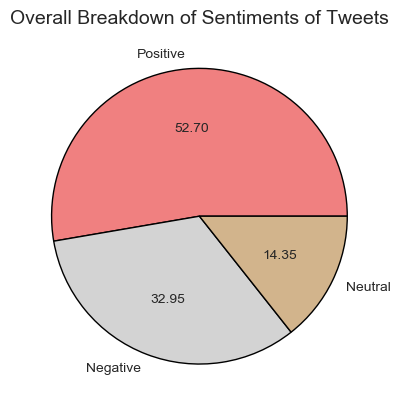

In [19]:
# Show simple pie chart of sentiment
plt.rcParams['patch.linewidth'] = 1  
plt.rcParams['patch.edgecolor'] = 'black'
colors=["lightcoral", "lightgrey", "tan"]
plt.pie(df["sentiment"].value_counts(normalize = True),labels=["Positive", "Negative", "Neutral"], colors=colors, autopct='%.2f')
plt.title("Overall Breakdown of Sentiments of Tweets", fontsize=14)
plt.show()


As can be seen above, almost a third of all tweets are considered  Negative (have a polarity score less than zero) and  about 14% are considered Neutral. That means that a majority of tweets are considered positive.

### Democratic tweets vs. Republican tweets

Next, we take a look at these two categories, Democratic vs. Republican, to see if there is a difference in distribution of positive vs. neutral vs. negative tweets. First, we will look at overall counts grouped by political affiliation and sentiment, then we will look at the distribution of polarity scores for each political group.

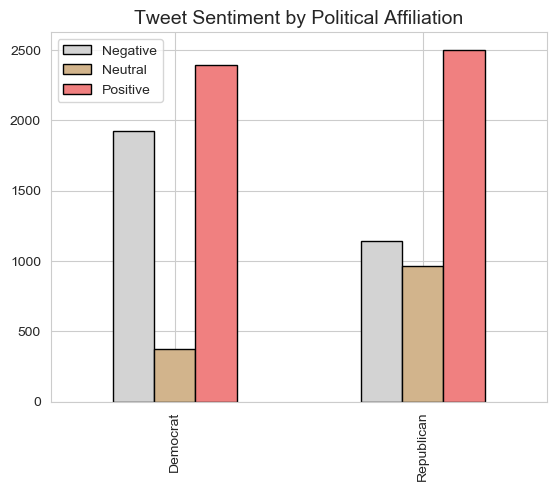

In [20]:
colors=["lightgrey","tan", "lightcoral"]
df_by_affil = df.groupby(['sentiment','PoliticalAffil']).size().reset_index(name='Count')
df_by_affil_pivot = pd.pivot_table(df_by_affil,  values='Count',  columns=['sentiment'],  index = "PoliticalAffil",
                         aggfunc=np.sum,  fill_value=0)
df_by_affil_pivot.plot(kind="bar",  edgecolor='black',color=colors)
plt.legend( loc=2)
plt.title("Tweet Sentiment by Political Affiliation", fontsize=14)
plt.xlabel('')
plt.show()

As can be seen, Democrats have almost twice the number of negative tweets, and slightly less positive tweets than Republicans. This could have something to do with the fact that during the 2019 year, the president of the United States (belonging to the opposite party of congressional Democrats) was in the process of being impeached by those Democrats.

### Visualization of Polarity Scores grouped by Political Affiliation

The histograms below are not including those tweets with zero polarity so that we can more easily compare the distributions of the non-zero (negative and positive) polarity tweets, however, zero polarity tweets are included in the calculations of the mean polarity scores for both groups of politicians. These mean values are shown below as red verticle lines.

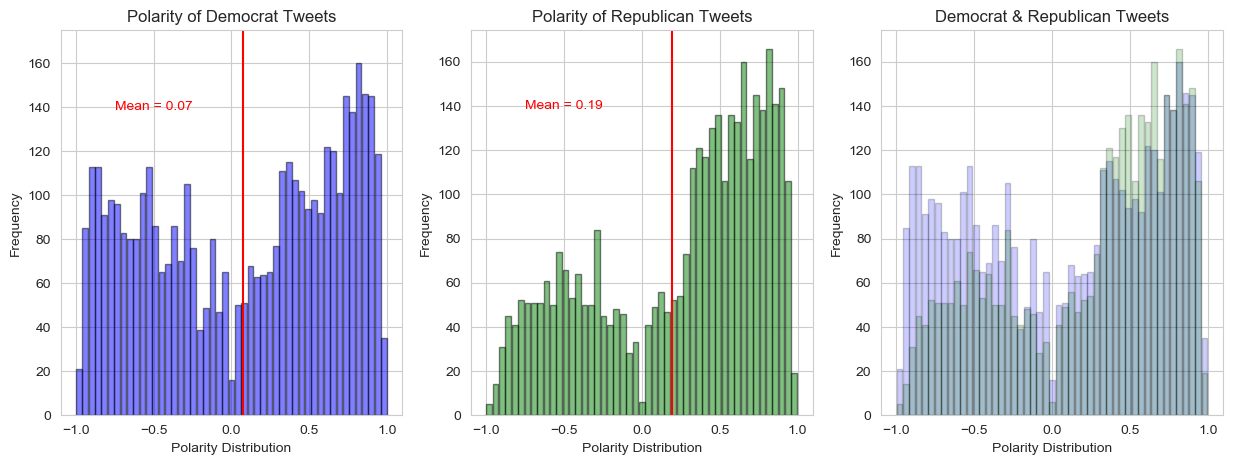

In [24]:

non_zero = df["compound"]!=0
dem_tweets=df["Democrat"]==True
rep_tweets=df["Democrat"]!=True

df_dem = df[non_zero & dem_tweets]
df_rep = df[non_zero & rep_tweets]

# Plot histograms for polarity scores for the two different political groups, one for each group and one overlapping to see the difference
fig, axes = plt.subplots(1,3, figsize=(15, 5))
bins = np.linspace(-1, 1, 50)
dem_pol_scores=df.loc[dem_tweets, "compound"]
rep_pol_scores=df.loc[rep_tweets, "compound"]
dem_polarity_mean=dem_pol_scores.mean()
rep_polarity_mean=rep_pol_scores.mean()

df.loc[non_zero & dem_tweets, "compound" ].plot.hist(bins = bins, rwidth=0.9, title='Polarity of Democrat Tweets', edgecolor='black', alpha=0.5, color="blue", ax = axes[0])
axes[0].axvline(dem_polarity_mean, color='red')
axes[0].set_xlabel("Polarity Distribution")
axes[0].text(-.5, 140, 'Mean = ' + str(round(dem_polarity_mean,2)), size=10, ha='center', va='center', color="red")
axes[0].set_ylim([0,175])

df.loc[non_zero & rep_tweets, "compound" ].plot.hist(bins = bins, rwidth=0.9, title='Polarity of Republican Tweets', edgecolor='black', alpha=0.5, color="green", ax = axes[1])
axes[1].axvline(rep_polarity_mean, color='red')
axes[1].set_xlabel("Polarity Distribution")
axes[1].text(-.5, 140, 'Mean = ' + str(round(rep_polarity_mean,2)), size=10, ha='center', va='center', color="red")

df.loc[non_zero & dem_tweets, "compound" ].plot.hist(bins = bins, rwidth=0.9, title='Democrat & Republican Tweets', edgecolor='black', alpha=0.2, color="blue", ax = axes[2])
df.loc[non_zero & rep_tweets, "compound" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[2])
axes[2].set_xlabel("Polarity Distribution")

plt.show()


<b>Is the difference in average polarity scores significant?</b>

To check, let's run a quick test and look at the resulting statistic and p-value.

Since the distributions of the polarity scores do not conform to a normal distribution, we will use the Mann-Whitney U Test instead of the t-test.

In [30]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dem_pol_scores, rep_pol_scores)
print("The test statistic is " + str(stat) + " and the p-value is " + str(p))
significant

The test statistic is 9565826.5 and the p-value is 1.4856454486748421e-21


These histograms show not only do the Democrats have more negative tweets than the Republicans, but that the negative tweets are skewed towards the very negative (keep in mind that a polarity score of -1 indicates the most negative a tweet can be). Our statistical test show that we can reject the null hypothesis that the means of the two distributions are from the same population, in other words, there is a statistically significant difference.

### Visualization of Number of Likes by Sentiment Polarity

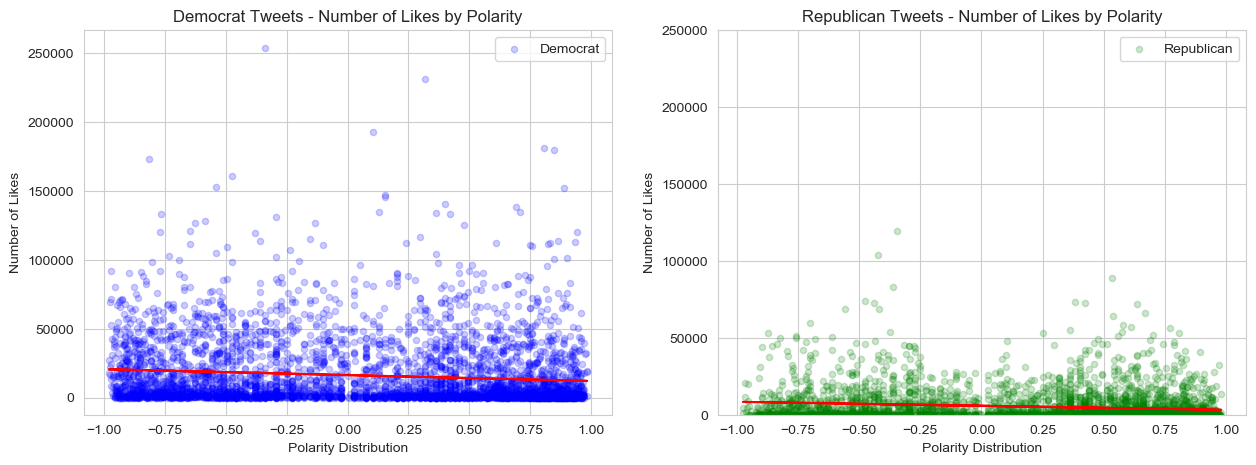

In [31]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

df_dem.plot.scatter(x='compound', y='likes', title='Democrat Tweets - Number of Likes by Polarity', ax=axes[0],color='blue',  alpha=.20, label='Democrat')
axes[0].set_xlabel("Polarity Distribution")
axes[0].set_ylabel("Number of Likes")
axes[0].plot(df_dem['compound'], get_regress_line(df_dem['compound'],df_dem['likes'] ), 'r')

df_rep.plot.scatter(x='compound', y='likes', title='Republican Tweets - Number of Likes by Polarity', ax=axes[1],color='green',  alpha=.20, label='Republican')
axes[1].set_ylim([0,250000])
axes[1].set_xlabel("Polarity Distribution")
axes[1].set_ylabel("Number of Likes")
axes[1].plot(df_rep['compound'], get_regress_line(df_rep['compound'],df_rep['likes'] ), 'r')
plt.show()

These two scatter plots, along with the red regression lines, show that there is very little correlation between number of likes and the sentiment (compound = polarity) of tweets for either party. The most interesting revelation from the scatter plots above is that the Democratic tweets seem to get many more likes.

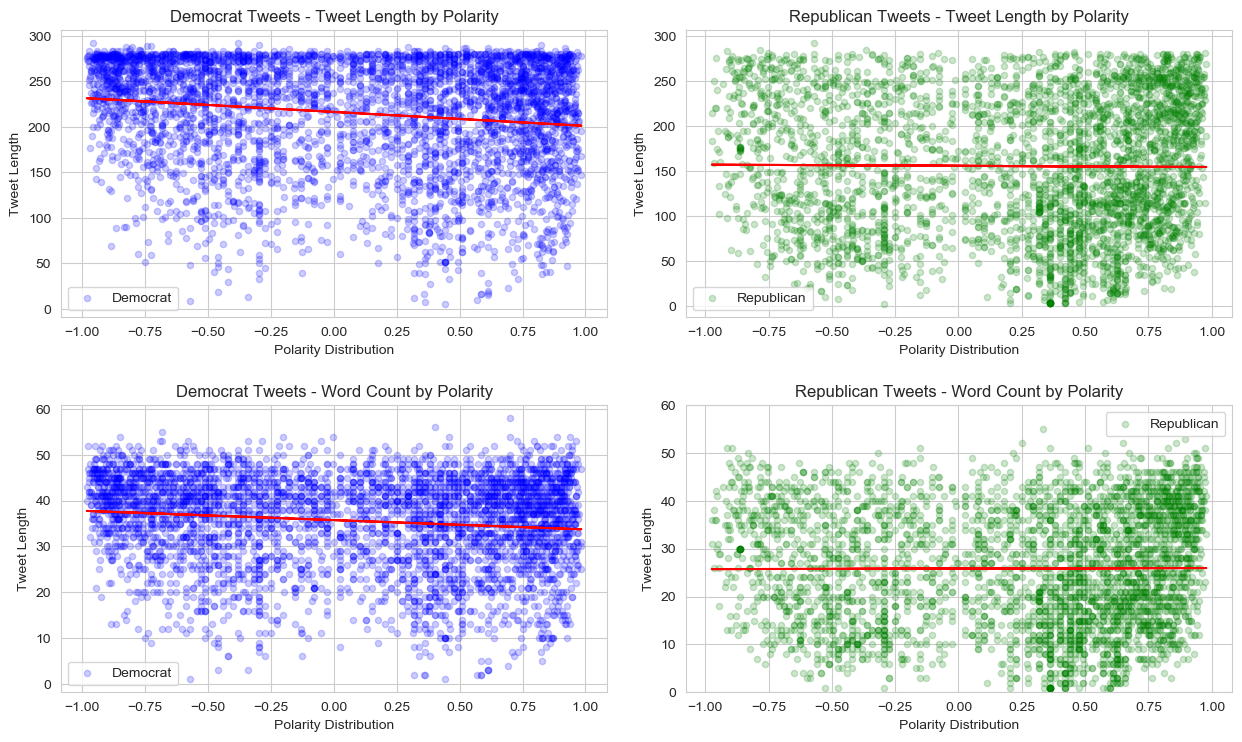

In [32]:

# Crete a scatter plots on variables (number of likes and sentiment polarity) to see if there is relationship
fig, axes = plt.subplots(2,2, figsize=(15, 10))

df_dem.plot.scatter(x='compound', y='tweet_len', title='Democrat Tweets - Tweet Length by Polarity', ax=axes[0,0],color='blue',  alpha=.20, label='Democrat')
axes[0,0].set_xlabel("Polarity Distribution")
axes[0,0].set_ylabel("Tweet Length")
axes[0,0].plot(df_dem['compound'], get_regress_line(df_dem['compound'],df_dem['tweet_len'] ), 'r')

df_rep.plot.scatter(x='compound', y='tweet_len', title='Republican Tweets - Tweet Length by Polarity', ax=axes[0,1],color='green',  alpha=.20, label='Republican')
axes[0,1].set_xlabel("Polarity Distribution")
axes[0,1].set_ylabel("Tweet Length")
axes[0,1].plot(df_rep['compound'], get_regress_line(df_rep['compound'],df_rep['tweet_len'] ), 'r')

df_dem.plot.scatter(x='compound', y='word_count', title='Democrat Tweets - Word Count by Polarity', ax=axes[1,0],color='blue',  alpha=.20, label='Democrat')
axes[1,0].set_xlabel("Polarity Distribution")
axes[1,0].set_ylabel("Tweet Length")
axes[1,0].plot(df_dem['compound'], get_regress_line(df_dem['compound'],df_dem['word_count'] ), 'r')

df_rep.plot.scatter(x='compound', y='word_count', title='Republican Tweets - Word Count by Polarity', ax=axes[1,1],color='green',  alpha=.20, label='Republican')
axes[1,1].set_ylim([0,60])
axes[1,1].set_xlabel("Polarity Distribution")
axes[1,1].set_ylabel("Tweet Length")
axes[1,1].plot(df_rep['compound'], get_regress_line(df_rep['compound'],df_rep['word_count'] ), 'r')

plt.tight_layout(pad=10, w_pad=2, h_pad=2.0)
plt.show()

Although there is clearly no correlation between tweet length and sentiment polarity for the Republicans, there is a slight correlation for the Democrats, as can be seen by the red regression lines above. The interesting takeaway from distribution of the scatter plots above, is that it seems to show that Democratic tweets tend to be longer than Republican tweets. There also seems to be a cluster of very long, very negative tweets for Democrats and not so for Republicans.

To confirm our suspicion, let's look at histograms of tweet lengths for the two groups.

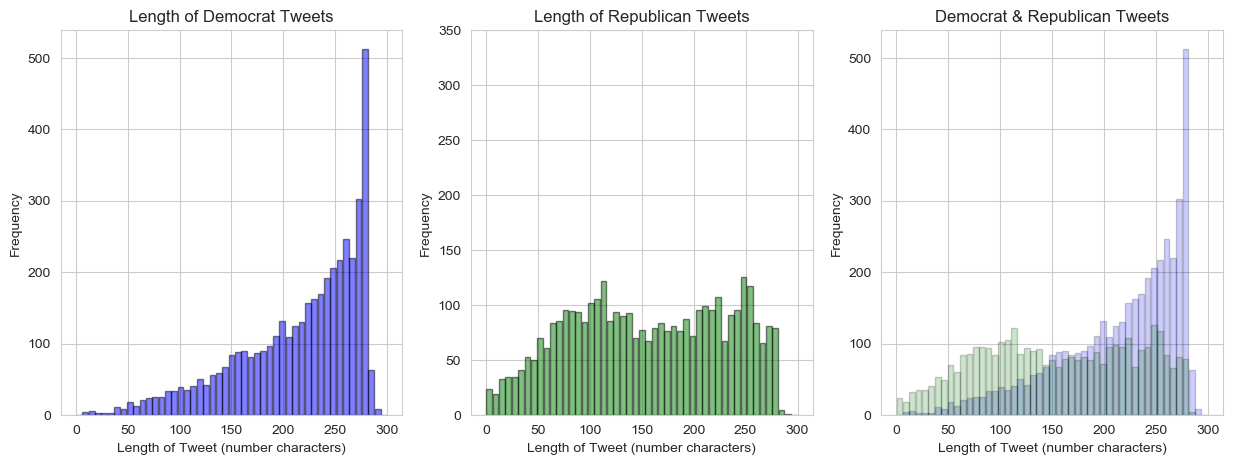

In [33]:

# Plot histograms for polarity scores for the two different political groups, one for each group and one overlapping to see the difference
fig, axes = plt.subplots(1,3, figsize=(15, 5))
bins = np.linspace(0,300, 50)
axes[1].set_ylim([0,350])
df.loc[non_zero & dem_tweets, "tweet_len" ].plot.hist(bins = bins, rwidth=0.9, title='Length of Democrat Tweets', edgecolor='black', alpha=0.5, color="blue", ax = axes[0])
df.loc[non_zero & rep_tweets, "tweet_len" ].plot.hist(bins = bins, rwidth=0.9, title='Length of Republican Tweets', edgecolor='black', alpha=0.5, color="green", ax = axes[1])
df.loc[non_zero & dem_tweets, "tweet_len" ].plot.hist(bins = bins, rwidth=0.9, title='Democrat & Republican Tweets', edgecolor='black', alpha=0.2, color="blue", ax = axes[2])
df.loc[non_zero & rep_tweets, "tweet_len" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[2])
axes[0].set_xlabel("Length of Tweet (number characters)")
axes[1].set_xlabel("Length of Tweet (number characters)")
axes[2].set_xlabel("Length of Tweet (number characters)")
plt.show()

Clearly Democratic tweets are quite a bit more skewed towards being longer than the Republic tweets.

### Word Clouds for Categories of Tweets

Before we create word clouds, we will go ahead and process our tweet text a bit more. So far we have only cleaned the tweet text with our "CleanTweets" function, but have not removed stop-words or other non-alpha characters that may get in the way of creating interesting word clouds. We accomplish this by feeding our clean_tweet text through a couple functions.

In [34]:
df["clean_tweet"] = df["clean_tweet"].apply(ProcessText)
df["clean_tweet"] = df["clean_tweet"].apply(remove_stop_words)


In [35]:
pos_tweets=df["sentiment"]=="Positive"
neg_tweets=df["sentiment"]=="Negative"

### Word Clouds

Next, we look at word clouds for four categories; Positive  Democratic tweets, Negative Democratic tweets,   Positive Republican tweets and Negative  Republican tweets. It will be interesting to see if we can guess the popular subjects of tweets based on popular words.

#### Word Cloud for Democratic Positive Tweets

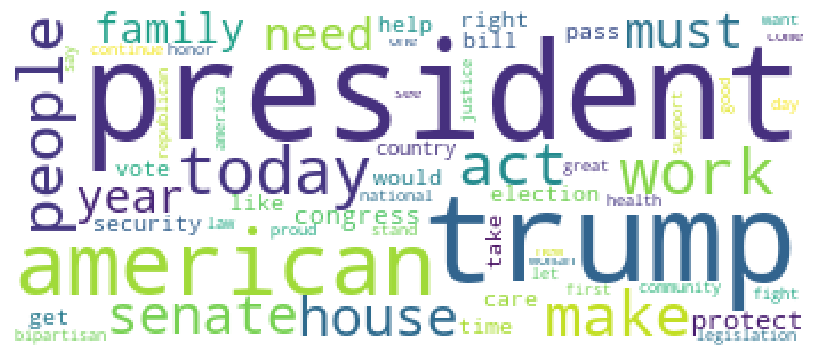

In [36]:
show_word_cloud_for_tweets(df[dem_tweets & pos_tweets])

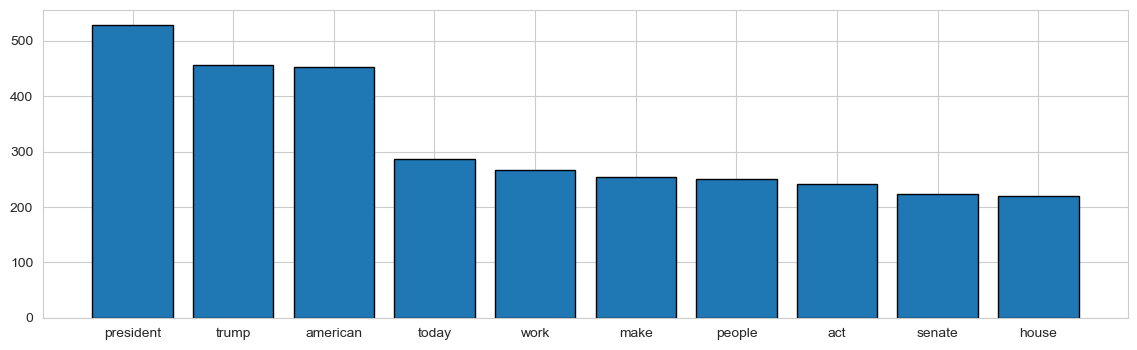

In [64]:
words, count =count_common(df[dem_tweets & pos_tweets], 10) 
f, ax = plt.subplots(figsize=(14,4))
plt.bar(words,count)
plt.show()

As expected, the subject matter seems very political/government oriented, with words like American, president, congress, senate, act, vote, country and election.
 
 #### Word Cloud for Democratic Negative Tweets

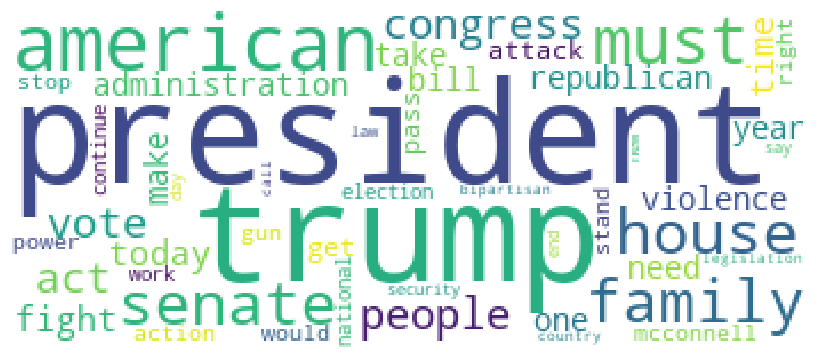

In [37]:
show_word_cloud_for_tweets(df[dem_tweets & neg_tweets])

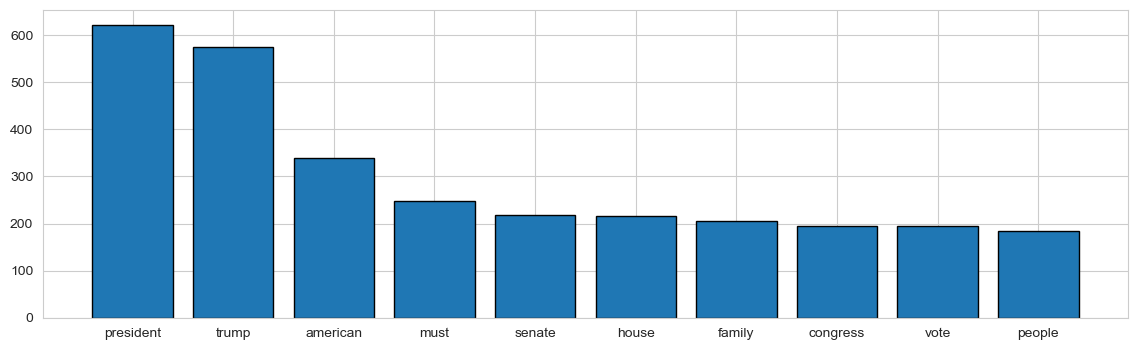

In [65]:
words, count =count_common(df[dem_tweets & neg_tweets], 10) 
f, ax = plt.subplots(figsize=(14,4))
plt.bar(words,count)
plt.show()

Clearly the word "President" is a very common word in both positive and negative tweets. I'm a bit surprised it shows up so often in the Democrat's positive tweets, although it does make sense that the word "Trump" is more prevalent in the negative tweets. Finally, I find it odd that the word "Republican" is not more common in the negative tweets.

The subject matter doesn't seem much different than the positive tweets, except for the prevalence of a few clearly negative words like fight, gun, attack (and it looks like the word "McConnell" snuck in, which isn't too surprising.) 

### Word Cloud for Republican Positive Tweets

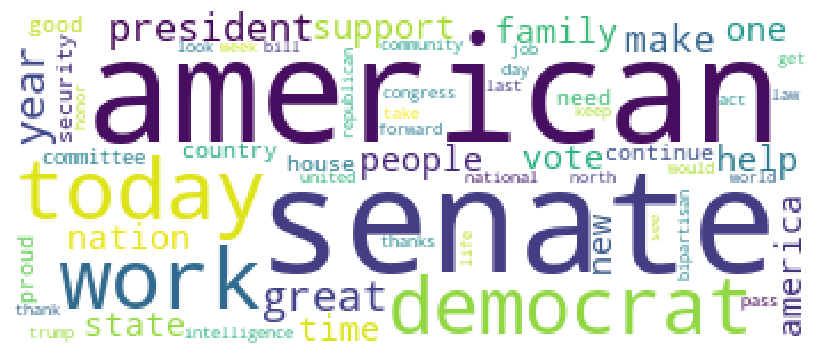

In [38]:
show_word_cloud_for_tweets(df[rep_tweets & pos_tweets])

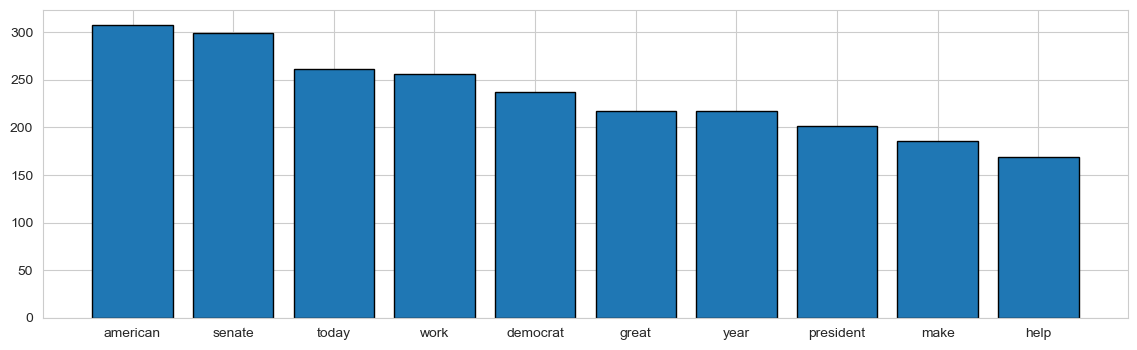

In [66]:
words, count =count_common(df[rep_tweets & pos_tweets], 10) 
f, ax = plt.subplots(figsize=(14,4))
plt.bar(words,count)
plt.show()

Like the first two word clouds, this one also seem very much about government. Interesting that the word tax snuck in, but maybe understandable considering the Republicans passed a massive tax cut the year before that they are very proud of.

### Word Cloud for Republican Negative Tweets

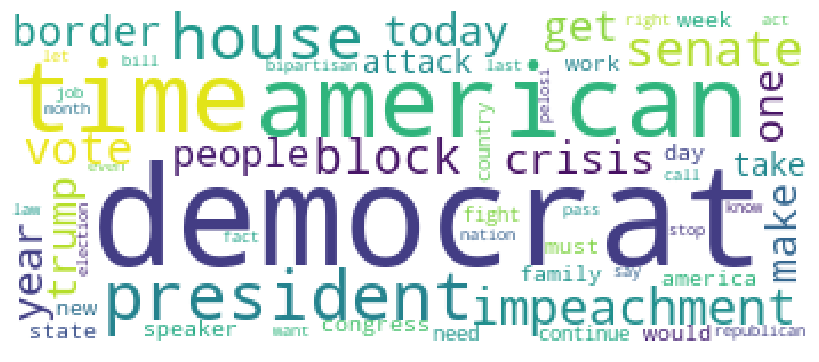

In [39]:
show_word_cloud_for_tweets(df[rep_tweets & neg_tweets])

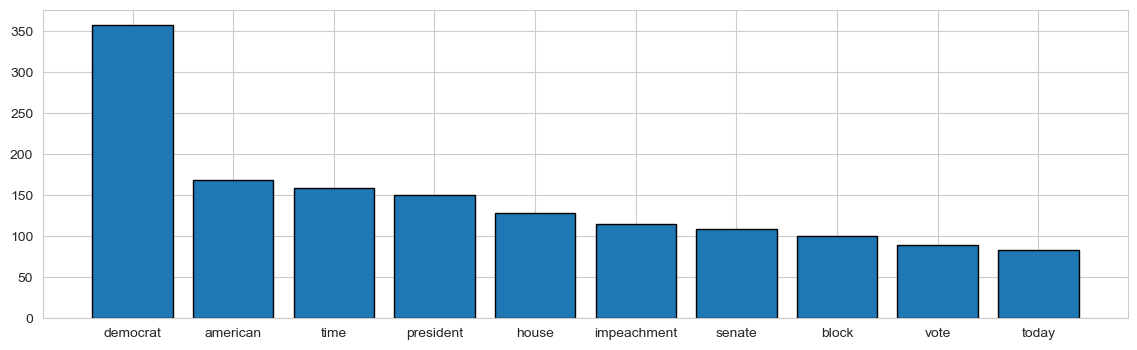

In [67]:
words, count =count_common(df[rep_tweets & neg_tweets], 10) 
f, ax = plt.subplots(figsize=(14,4))
plt.bar(words,count)
plt.show()

Contrary to the fact that the Democratic tweets did not overly use the word 'Republican', the word cloud of the negative Republican tweets clearly shows that most common word is "Democrat"!

### Summary

This project started with the creation of a custom dataset by pulling tweets from twitter. We were then able to employ some NLP techniques that can be useful in many domains; pre-processing, cleaning and analyzing text data. Without knowing what interesting (or not so interesting) trends we would find ahead of time, we were able to display what we did find in an intuitive way, using just pyplot graphs and word clouds.

The main takeaways from our data analysis could include the follows: 

1. Most tweets tend to be more positive than negative.

2. Republican tweets tend to be more positive than Democratic tweets.

3. Democratic tweets tend to get “liked” more and tend to be longer.

4. With a few exceptions, word clouds for Republican vs. Democratic tweets, Positive vs. Negative are surprisingly similar, showing a consistent theme of “government” oriented topics.  Although maybe not surprising considering that all these tweets were written by political government employees.

The important takeaway for me is that these techniques can be applied to any subset of tweets that might be interesting, be it those that are trending, or connected to a specific hashtag, subject, product or organization. Monitoring the sentiment of tweets over time can allow one to identify changes in public sentiment about various entities. If the monitoring was done in real time, this could prove quite beneficial if alerts could allow one to quickly identify and remedy (if need be)  the cause.   



<a href="https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f">Simplifying Sentiment Analysis using VADER in Python (on Social Media Text)</a> by Parul Pandey

<a href="https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a">A Complete Exploratory Data Analysis and Visualization for Text Data</a> by Susan Li


